# Set up

The following package will download the TSV files from IMDB website and store the data into a SQLite database (requires 10GB of disk space)


In [1]:
!pip install imdb-sqlite

In [2]:
%%time
!imdb-sqlite

2022-01-07 14:38:49,852 DB already exists: (imdb.db). Refusing to modify. Exiting
CPU times: user 11.7 ms, sys: 433 µs, total: 12.2 ms
Wall time: 245 ms


In [3]:
# Need this package for hadling country ISO codes
!pip install pycountry

In [4]:
# Imports

import re
import time
import sqlite3
import pycountry
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from matplotlib import cm # Color maps
from sklearn.feature_extraction.text import CountVectorizer # Convert a collection of text documents to a matrix of token counts

In [5]:
# Some tweaks

warnings.filterwarnings('ignore') # Don't show warnings
sns.set_theme(style = 'whitegrid')

# Database structure analysis

In [6]:
# Connect to databse
conn = sqlite3.connect('imdb.db')

In [7]:
# Retrieve tables' names
tables = pd.read_sql_query('SELECT name AS "Table_name" FROM sqlite_master WHERE type="table"', conn)
tables.head()

,Table_name
0,people
1,titles
2,akas
3,crew
4,episodes


In [8]:
# Retrieve each table's schema

tables_names = tables['Table_name'].values.tolist()

for table_name in tables_names:
    schema = pd.read_sql_query(f'PRAGMA TABLE_INFO({table_name})', conn)
    print(f'Schema for table {table_name}:')
    display(schema)
    print(f'{50 * "_"}\n\n')

Schema for table people:


,cid,name,type,notnull,dflt_value,pk
0,0,person_id,VARCHAR,0,None,1
1,1,name,VARCHAR,0,None,0
2,2,born,INTEGER,0,None,0
3,3,died,INTEGER,0,None,0


__________________________________________________


Schema for table titles:


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,type,VARCHAR,0,None,0
2,2,primary_title,VARCHAR,0,None,0
3,3,original_title,VARCHAR,0,None,0
4,4,is_adult,INTEGER,0,None,0
5,5,premiered,INTEGER,0,None,0
6,6,ended,INTEGER,0,None,0
7,7,runtime_minutes,INTEGER,0,None,0
8,8,genres,VARCHAR,0,None,0


__________________________________________________


Schema for table akas:


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,title,VARCHAR,0,None,0
2,2,region,VARCHAR,0,None,0
3,3,language,VARCHAR,0,None,0
4,4,types,VARCHAR,0,None,0
5,5,attributes,VARCHAR,0,None,0
6,6,is_original_title,INTEGER,0,None,0


__________________________________________________


Schema for table crew:


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,person_id,VARCHAR,0,None,0
2,2,category,VARCHAR,0,None,0
3,3,job,VARCHAR,0,None,0
4,4,characters,VARCHAR,0,None,0


__________________________________________________


Schema for table episodes:


,cid,name,type,notnull,dflt_value,pk
0,0,episode_title_id,INTEGER,0,None,0
1,1,show_title_id,INTEGER,0,None,0
2,2,season_number,INTEGER,0,None,0
3,3,eposide_number,INTEGER,0,None,0


__________________________________________________


Schema for table ratings:


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,rating,INTEGER,0,None,0
2,2,votes,INTEGER,0,None,0


__________________________________________________




# 1. The most common content categories in IMDB

In [9]:
# Retrieve the data
query = 'SELECT type, COUNT(*) AS abs_frequency FROM titles GROUP BY type ORDER BY abs_frequency DESC'
dataframe = pd.read_sql_query(query, conn)
display(dataframe)

,type,abs_frequency
0,tvEpisode,6404250
1,short,849453
2,movie,598170
3,video,256280
4,tvSeries,218814
5,tvMovie,134354
6,tvMiniSeries,41405
7,tvSpecial,35501
8,videoGame,30088
9,tvShort,10427


In [10]:
# Remove tvEpisode type
dataframe = dataframe.drop(labels = 0, axis = 0)

In [11]:
# Add the relative_frequency
sum_abs_freq = dataframe['abs_frequency'].sum()
dataframe['rel_frequency'] = (dataframe['abs_frequency'] / sum_abs_freq) * 100
display(dataframe)

,type,abs_frequency,rel_frequency
1,short,849453,39.064398
2,movie,598170,27.508469
3,video,256280,11.785730
4,tvSeries,218814,10.062755
5,tvMovie,134354,6.178633
6,tvMiniSeries,41405,1.904121
7,tvSpecial,35501,1.632610
8,videoGame,30088,1.383678
9,tvShort,10427,0.479514
10,tvPilot,2,0.000092


Now let's create a graph with 5 categories:

4 categories with the the biggest amount of titles.

1 category with the others


In [12]:
# Others category
others = {}
others['type'] = 'others'
others['abs_frequency'] = dataframe.iloc[4:]['abs_frequency'].sum()
others['rel_frequency'] = dataframe.iloc[4:]['rel_frequency'].sum()
others

{'type': 'others',
 'abs_frequency': 251777,
 'rel_frequency': 11.578647722182724}

In [13]:
# The common title categories dataframe
dataframe = dataframe.head(4)
dataframe = dataframe.append(others, ignore_index = True) # Append others category
dataframe = dataframe.sort_values(by = 'rel_frequency', ascending = False)
dataframe

,type,abs_frequency,rel_frequency
0,short,849453,39.064398
1,movie,598170,27.508469
2,video,256280,11.785730
4,others,251777,11.578648
3,tvSeries,218814,10.062755


In [14]:
# Labels
labels = []

for i in dataframe.index:
    cont_type = dataframe.loc[i]["type"]
    cont_type = re.sub(r"(\w)([A-Z])", r"\1 \2", cont_type) # Add space before capital letters
    cont_type = cont_type[0].upper() + cont_type[1:] # Uppercase the first letter without changing the rest
    
    rel_freq = round(dataframe.loc[i]["rel_frequency"], 2)
    
    labels.append(f'{cont_type} {rel_freq}%')
    
labels

['Short 39.06%',
 'Movie 27.51%',
 'Video 11.79%',
 'Others 11.58%',
 'Tv Series 10.06%']

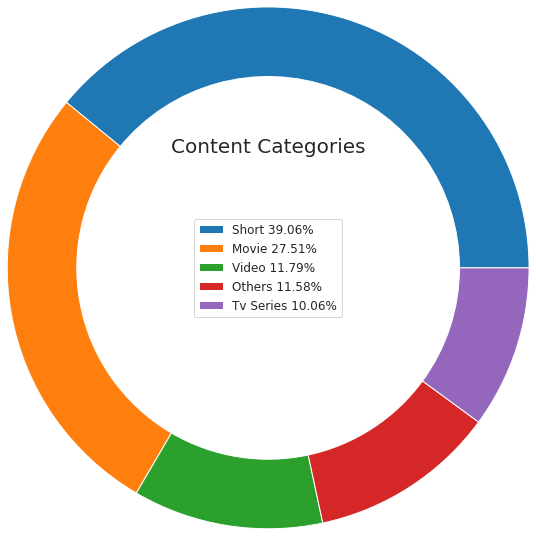

In [15]:
# Plot

# Set color map
# https://matplotlib.org/stable/tutorials/colors/colormaps.html
cs = cm.tab10(range(100))

plt.pie(dataframe['rel_frequency'], colors = cs, labeldistance = 1, radius = 3, wedgeprops = dict(width = 0.8))
plt.legend(labels = labels, loc = 'center', fontsize = 12)
plt.title(label = 'Content Categories', loc = 'center', fontdict = {'fontsize':20,'fontweight':20})
plt.show()



# 2. Percentage of movies per genre

In [16]:
# Retrieve movie genres and sort them
query = 'SELECT genres FROM titles WHERE type="movie"'
dataframe = pd.read_sql_query(query, conn)
display(dataframe)

,genres
0,\N
1,"Action,Adventure,Biography"
2,Drama
3,Drama
4,Drama
...,...
598165,Documentary
598166,Documentary
598167,Comedy
598168,\N


In [17]:
# Lowercase genres
dataframe['genres'] = dataframe['genres'].str.lower()

In [18]:
# Remove missing values (\N)
dataframe['genres'].replace('\\n', np.nan, inplace = True)
genres_df = dataframe['genres'].dropna()
display(genres_df)

1         action,adventure,biography
2                              drama
3                              drama
4                              drama
5                              drama
                     ...            
598164                         drama
598165                   documentary
598166                   documentary
598167                        comedy
598169                   documentary
Name: genres, Length: 526984, dtype: object

#### How CountVectorizer works:

![How CountVectorizer works](https://mlwhiz.com/images/countvectorizer.png)

In [19]:
# Match words with lenght > 1 and with - or not
# We use count vectorizer to count the genderr' frequencies
pattern = '(?u)\\b\\w[\\w-]+\\b'
vect = CountVectorizer(token_pattern = pattern).fit(genres_df)
vect

CountVectorizer(token_pattern='(?u)\\b\\w[\\w-]+\\b')

In [20]:
# Create Document-term matrix.

bag_genres = vect.transform(genres_df)
bag_genres

<526984x28 sparse matrix of type '<class 'numpy.int64'>'
	with 805703 stored elements in Compressed Sparse Row format>

In [21]:
# Return token names

unique_genres = vect.get_feature_names()
unique_genres

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [22]:
# Sum sparse matrix columns
genres_abs_freq = bag_genres.toarray().sum(axis = 0)
genres_abs_freq

array([ 50125,   8373,  26155,   8000,  15732, 101597,  34241, 110581,
       214746,  16540,  14014,    764,     20,  13123,  32954,  11071,
         9764,  15437,   1431,    445,  44035,  12746,     58,   6361,
          141,  40393,   8906,   7950])

In [23]:
# Sum of absolute frequencies
freq_total_sum = genres_abs_freq.sum()
freq_total_sum

805703

In [24]:
# Create final dataframe
genres_df = pd.DataFrame(zip(unique_genres, genres_abs_freq), columns = ['genre', 'abs_freq'])

In [25]:
# Sort by absolute frequency
genres_df = genres_df.sort_values(by = 'abs_freq', ascending = False)
genres_df

,genre,abs_freq
8,drama,214746
7,documentary,110581
5,comedy,101597
0,action,50125
20,romance,44035
25,thriller,40393
6,crime,34241
14,horror,32954
2,adventure,26155
9,family,16540


In [26]:
# Add relative frequencies to dataframe
genres_df['rel_freq'] = [(abs_freq / freq_total_sum) * 100 for abs_freq in genres_df['abs_freq']]
genres_df

,genre,abs_freq,rel_freq
8,drama,214746,26.653246
7,documentary,110581,13.724784
5,comedy,101597,12.609733
0,action,50125,6.221275
20,romance,44035,5.465413
25,thriller,40393,5.013386
6,crime,34241,4.249829
14,horror,32954,4.090093
2,adventure,26155,3.246233
9,family,16540,2.052866


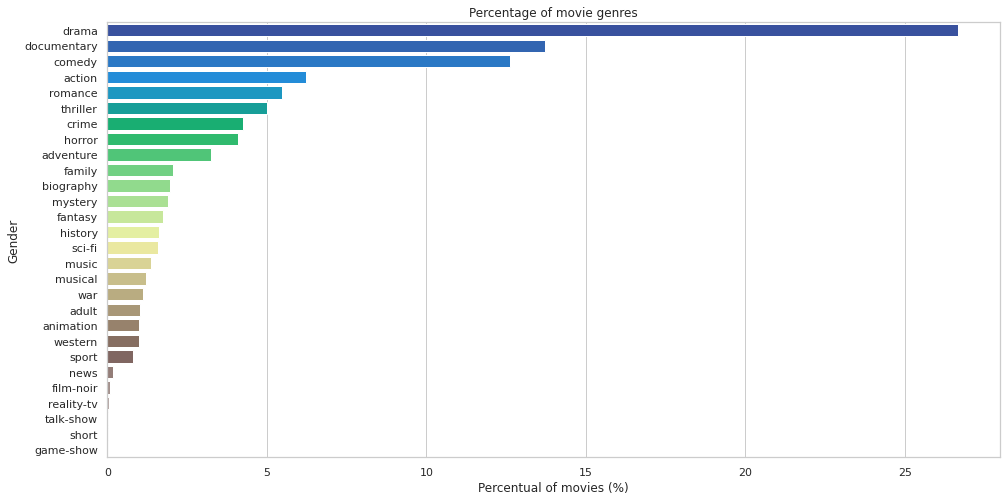

In [28]:
# Plot

plt.figure(figsize = (16, 8))
sns.barplot(x = genres_df['rel_freq'].tolist(), y = genres_df['genre'].tolist(), orient = 'h', palette = 'terrain')
plt.ylabel('Gender')
plt.xlabel('Percentual of movies (%)')
plt.title('Percentage of movie genres')
plt.show()
